In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format ='retina'
from datetime import datetime, timedelta
import pandas_datareader.data as web
from operator import itemgetter
import pyfolio as pf
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 70)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.exceptions import NotFittedError

/Users/thibaut/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/Users/thibaut/opt/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
start = datetime(2016,1,1)
end = datetime(2020,1,1)
now = datetime.today()
asset = '^STOXX50E'
df = web.DataReader(asset,'yahoo',start,now)

In [3]:
df[str(asset)] = df['Close']
df_asset = df.drop(['High','Low','Open','Close','Volume','Adj Close'],inplace=False,axis=1)

In [4]:
def rsi_generator(asset,window):
    delta = df[asset].diff()
    up_days = delta.copy()
    up_days[delta<=0]=0.0
    down_days = abs(delta.copy())
    down_days[delta>0]=0.0
    RS_up = up_days.rolling(window).mean()
    RS_down = down_days.rolling(window).mean()
    rsi = 100-100/(1+RS_up/RS_down)
    return rsi

In [5]:
def technicals(asset,df,window,rsi_width,mult):
    
    #Create 1 ST and 1 LT Moving Average, the ratio of length between two determined by 2*mult
    df[str(window)+' period MA'] = df[asset].rolling(window).mean()
    df[str(int(window*2*mult))+' period MA'] = df[asset].rolling(int(window*2*mult)).mean()
    
    #Create RSI indicator
    rsi = rsi_generator(asset=asset,window=window)
    df['RSI']= rsi
    
    #Create Composite Index (connie brown)
    step1 = rsi_generator(asset,window=14)-rsi_generator(asset,window=14).shift(9)
    step2 = rsi_generator(asset,window=3).rolling(3).mean()
    step3 = step1 + step2
    df['Composite Index Indicator'] = step3
    #df['CI 13d Average'] = step3.rolling(13).mean()
    #df['CI 33d Average'] = step3.rolling(33).mean()
    
    #Create RSI bands of rsi_width around 50 midpoint
    df[str(50+rsi_width)] = 50+rsi_width
    df[str(50-rsi_width)] = 50-rsi_width
    
    #Create MACD signal
    exp1 = df[asset].ewm(span=12, adjust=False).mean()
    exp2 = df[asset].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean() 
    df['MACD'], df['signal_line'] = macd, signal
    
    return df

In [6]:
def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * (returns.mean() / returns.std())

In [7]:
def strategy_builder(asset,df,window,rsi_width,mult):
    
    #Creating Moving Average dictionary
    ma_dict = {}
    ma_dict[window] = df[asset].rolling(window).mean()
    ma_dict[int(window*2*mult)] = df[asset].rolling(int(window*2*mult)).mean()
    
    #Creating RSI
    rsi = rsi_generator(asset,window)
    df['RSI'] = rsi

    #Creating MACD
    exp1 = df[asset].ewm(span=12, adjust=False).mean()
    exp2 = df[asset].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean() 
    
    #Create Composite Index (connie brown)
    step1 = rsi_generator(asset,window=14)-rsi_generator(asset,window=14).shift(9)
    step2 = rsi_generator(asset,window=3).rolling(3).mean()
    step3 = step1 + step2
    df['Composite Index Indicator'] = step3
    
    #Return the max/min of asset and MACD of asset in last window*mult period
    spot_roll_max = df[asset].rolling(int(window*mult)).max().fillna(method='bfill')
    spot_roll_min = df[asset].rolling(int(window*mult)).min().fillna(method='bfill')
    macd_roll_max = macd.rolling(int(window*mult)).max().fillna(method='bfill')
    macd_roll_min = macd.rolling(int(window*mult)).min().fillna(method='bfill')
    
    #Apply a mask to a column of dates copied from index, and keep only the dates where spot==max/min, and np.nan otherwise and then ffill
    #Returns date of max/min within rolling period
    df['most_recent_spot_max'] = pd.DataFrame(df.index,index=df.index).mask(df[asset] != spot_roll_max, np.nan).fillna(method='ffill')
    df['most_recent_macd_max'] = pd.DataFrame(df.index,index=df.index).mask(macd != macd_roll_max, np.nan).fillna(method='ffill')
    df['most_recent_spot_min'] = pd.DataFrame(df.index,index=df.index).mask(df[asset] != spot_roll_min, np.nan).fillna(method='ffill')
    df['most_recent_macd_min'] = pd.DataFrame(df.index,index=df.index).mask(macd != macd_roll_min, np.nan).fillna(method='ffill')
   
    #Current date - date of last max/min to return number of calendar days since max/min, clipped at window*mult
    #As window is business days apply 1.5* to window*mult to increase limit for calendar day count
    df['days_since_spot_max'] = (df.index - df['most_recent_spot_max']).dt.days.clip(upper=int((window*1.5)*mult))
    df['days_since_macd_max'] = (df.index - df['most_recent_macd_max']).dt.days.clip(upper=int((window*1.5)*mult))
    df['days_since_spot_min'] = (df.index - df['most_recent_spot_min']).dt.days.clip(upper=int((window*1.5)*mult))
    df['days_since_macd_min'] = (df.index - df['most_recent_macd_min']).dt.days.clip(upper=int((window*1.5)*mult))
    
    #Calculate number of days between max/min of spot and MACD to create a measure of spot/macd divergence
    df['max_divergence'] = (df['days_since_macd_max']-df['days_since_spot_max'])
    df['min_divergence'] = (df['days_since_macd_min']-df['days_since_spot_min'])
    
    #creates a window length lag to the signal so trading buy/sell signal can use some memory of recent trend divergence
    df['max_divergence_lagged'] = df['max_divergence'].rolling(int(window)).max() 
    df['min_divergence_lagged'] = df['min_divergence'].rolling(int(window)).max() 
    
    #threshold at which point spot/MACD divergence is treated as a potential trading signal
    diverg_thresh=window
    
    #SIGNALS based on the simultaneous occurence of up(down)-trend (ST MA>LT MA), RSI above(below) threshold 
    #and Spot/MACD divergence beyond threshold of significance. Creates sell(buy) signal of -1(+1)
    df['SELL_SIG'] = np.where((ma_dict[window]>ma_dict[int(window*2*mult)])
                                            & (df['max_divergence_lagged']>diverg_thresh) 
                                            & (rsi>(50+rsi_width)),
                                                -1,0)
    
    df['BUY_SIG'] = np.where((ma_dict[window]<ma_dict[int(window*2*mult)])
                                    & ((df['min_divergence_lagged'])>diverg_thresh) 
                                    & (rsi<(50-rsi_width)),
                                                1,0)

    #Record date of sell signal, allows holding period of len(window) to be applied after signal created
    df['sell_sig_date'] = pd.DataFrame(df.index,index=df.index).mask(df['SELL_SIG'] != -1, np.nan).fillna(method='ffill')
    df['buy_sig_date'] = pd.DataFrame(df.index,index=df.index).mask(df['BUY_SIG'] != 1, np.nan).fillna(method='ffill')
    
    #Used to give precedence to buy of sell signal
    df['days_since_buy_sig'] = np.where((df.index - df['buy_sig_date']).dt.days > (window*1.5),0,
                                        (df.index - df['buy_sig_date']).dt.days)
    df['days_since_sell_sig'] = np.where((df.index - df['sell_sig_date']).dt.days > (window*1.5),0,
                                         (df.index - df['sell_sig_date']).dt.days)
    
    #Position held if active sell signal falls within rolling backward looking window
    df['active_sell_sig'] = np.where(df['SELL_SIG'].shift(1).rolling(window).sum() < 0, -1, 0)
    df['active_buy_sig'] = np.where(df['BUY_SIG'].shift(1).rolling(window).sum() > 0 , 1, 0)
    
    #Position dominance given to first signal created and window length holding period then applied until completed before opposing position can be taken
    df['position_first_signal'] = np.where(np.logical_and(df['active_sell_sig']==-1,df['active_buy_sig']==1), 
                                        np.where(df['days_since_buy_sig']>df['days_since_sell_sig'],1,-1),
                                        df[['active_sell_sig','active_buy_sig']].sum(axis=1))
    
    #Position dominance given to most recent signal, allows for a sell signal position to be held for only one period before flipping to a buy... deemed suboptimal
    df['position_modal_signal'] = df[['SELL_SIG','BUY_SIG']].shift(1).sum(axis=1).rolling(window).sum().clip(-1,1)
    
    #Strategy position log returns
    df[str(asset)+' log returns'] = np.log(df[asset]/df[asset].shift(1))
    df['position_returns_first'] = df[str(asset)+' log returns'] * df['position_first_signal']
    df['position_returns_modal'] = df[str(asset)+' log returns'] * df['position_modal_signal']
    
    # return last cumsum of log returns, sharpe, and whole dataframe
    return np.exp(df['position_returns_first'].cumsum())[-1], annualised_sharpe(df['position_returns_first']), df

In [8]:
strategy_builder(asset='^STOXX50E',df=df_asset,window=14,rsi_width=20,mult=2)[:2]

(1.7050023799880463, 0.7467349256103343)

In [9]:
def indicator_plot(asset,df,window,rsi_width,mult):
    #MAs
    ma_dict = {}
    ma_dict[window] = df[asset].rolling(window).mean()
    ma_dict[int(window*2*mult)] = df[asset].rolling(int(window*2*mult)).mean()
    #MAs plot
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(7,1,sharex=True,figsize=(16,15),gridspec_kw={'height_ratios':[1.3,0.7,1,1,0.5,1,0.7]})
    fig.suptitle(str(asset),y=1.02)
    ax1.grid()
    ax1.plot(df[asset])
    ax1.plot(ma_dict[window])
    ax1.plot(ma_dict[int(window*2*mult)])
    ax1.fill_between(df.index,ma_dict[window],ma_dict[int(window*2*mult)],ma_dict[window]>ma_dict[int(window*2*mult)],color='g',alpha=0.1)
    ax1.fill_between(df.index,ma_dict[window],ma_dict[int(window*2*mult)],ma_dict[window]<ma_dict[int(window*2*mult)],color='r',alpha=0.1)
    #RSI calc
    delta = df[asset].diff()
    up_days = delta.copy()
    up_days[delta<=0]=0.0
    down_days = abs(delta.copy())
    down_days[delta>0]=0.0
    RS_up = up_days.rolling(window).mean()
    RS_down = down_days.rolling(window).mean()
    rsi = 100-100/(1+RS_up/RS_down)
    #MACD calc
    exp1 = df[asset].ewm(span=12, adjust=False).mean()
    exp2 = df[asset].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean() 
    #Composite plot
    #Create Composite Index (connie brown)
    step1 = rsi_generator(asset,window=14)-rsi_generator(asset,window=14).shift(9)
    step2 = rsi_generator(asset,window=3).rolling(3).mean()
    step3 = step1 + step2
    #RSI bands plot
    ax2.grid()
    ax2.plot(rsi)
    ax2.plot(pd.Series(50+rsi_width,index=df.index))
    ax2.plot(pd.Series(50-rsi_width,index=df.index))
    ax2.fill_between(df.index,rsi,pd.Series(50+rsi_width,index=df.index),pd.Series(rsi>50+rsi_width,index=df.index),color='g',alpha=0.5)
    ax2.fill_between(df.index,rsi,pd.Series(50-rsi_width,index=df.index),pd.Series(rsi<50-rsi_width,index=df.index),color='r',alpha=0.5)
    ax2.set_ylabel('RSI')
    #MACD plot
    ax3.grid()
    ax3.plot(macd,label='MACD')
    ax3.plot(signal,label='Signal Line')
    ax3.legend()
    ax3.set_ylabel('MACD')
    ax3.fill_between(df.index,(macd-signal),0,macd>signal,color='g',alpha=0.5)
    ax3.fill_between(df.index,(macd-signal),0,macd<signal,color='r',alpha=0.5)
    ax3.legend()
    #threshold for length of spot/MACD divergence
    diverg_thresh = window
    #Divergence plots
    ax4.grid()
    ax4.plot(df['max_divergence_lagged'],label='Diverg. btwn Spot/MACD Maxes '+str(window)+'d lag (Sell Signal)',color='orange')
    ax4.plot(df['min_divergence_lagged'],label='Diverg. btwn Spot/MACD Mins '+str(window)+'d lag (Buy Signal)',color='tab:blue')
    ax4.axhline(diverg_thresh,linestyle='--',color='black',alpha=0.8)
    ax4.fill_between(df.index,df['max_divergence'].clip(lower=0),diverg_thresh,df['max_divergence']>diverg_thresh,color='orange',alpha=0.7)
    ax4.fill_between(df.index,df['min_divergence'].clip(lower=0),diverg_thresh,df['min_divergence']>diverg_thresh,color='tab:blue',alpha=0.7)
    ax4.legend()
    ax4.set_ylabel('Divergences')
    #Signals plot
    ax5.grid()
    ax5.plot(df['SELL_SIG'].shift(1),color='orange')
    ax5.plot(df['BUY_SIG'].shift(1),color='tab:blue')
    ax5.invert_yaxis()
    ax5.fill_between(df.index,df['SELL_SIG'].shift(1),0,df['SELL_SIG'].shift(1)<0,color='orange',alpha=1,step='mid')
    ax5.fill_between(df.index,df['BUY_SIG'].shift(1),0,df['BUY_SIG'].shift(1)>0,color='tab:blue',alpha=1,step='mid')
    ax5.set_ylabel('SIGNALS')
    #position returns plot
    ax6.grid()
    ax6.plot(np.exp(df['position_returns_first'].cumsum()),color='black',alpha=0.8)
    ax6.plot(np.exp(df['position_returns_modal'].cumsum()),color='black',alpha=0.7,linestyle='--')
    ax6.set_ylabel('Returns')
    ax6.fill_between(df.index,np.exp(df['position_returns_first']),1,np.exp(df['position_first_signal'])<1,color='orange')
    ax6.fill_between(df.index,np.exp(df['position_returns_first']),1,np.exp(df['position_first_signal'])>1,color='tab:blue')
    #Composite index plot (not used for signal)
    ax7.grid()
    ax7.set_ylabel('C.I. Indicator')
    ax7.plot(step3, label='Composite Index')
    #ax7.plot(step3.rolling(13).mean(), label='Composite Index 13d MA')
    ax7.plot(step3.rolling(33).mean(), label='Composite Index 33d MA')
    ax7.legend()
    
    fig.tight_layout(pad=0)

Cumsum Log Return:  1.7050023799880463


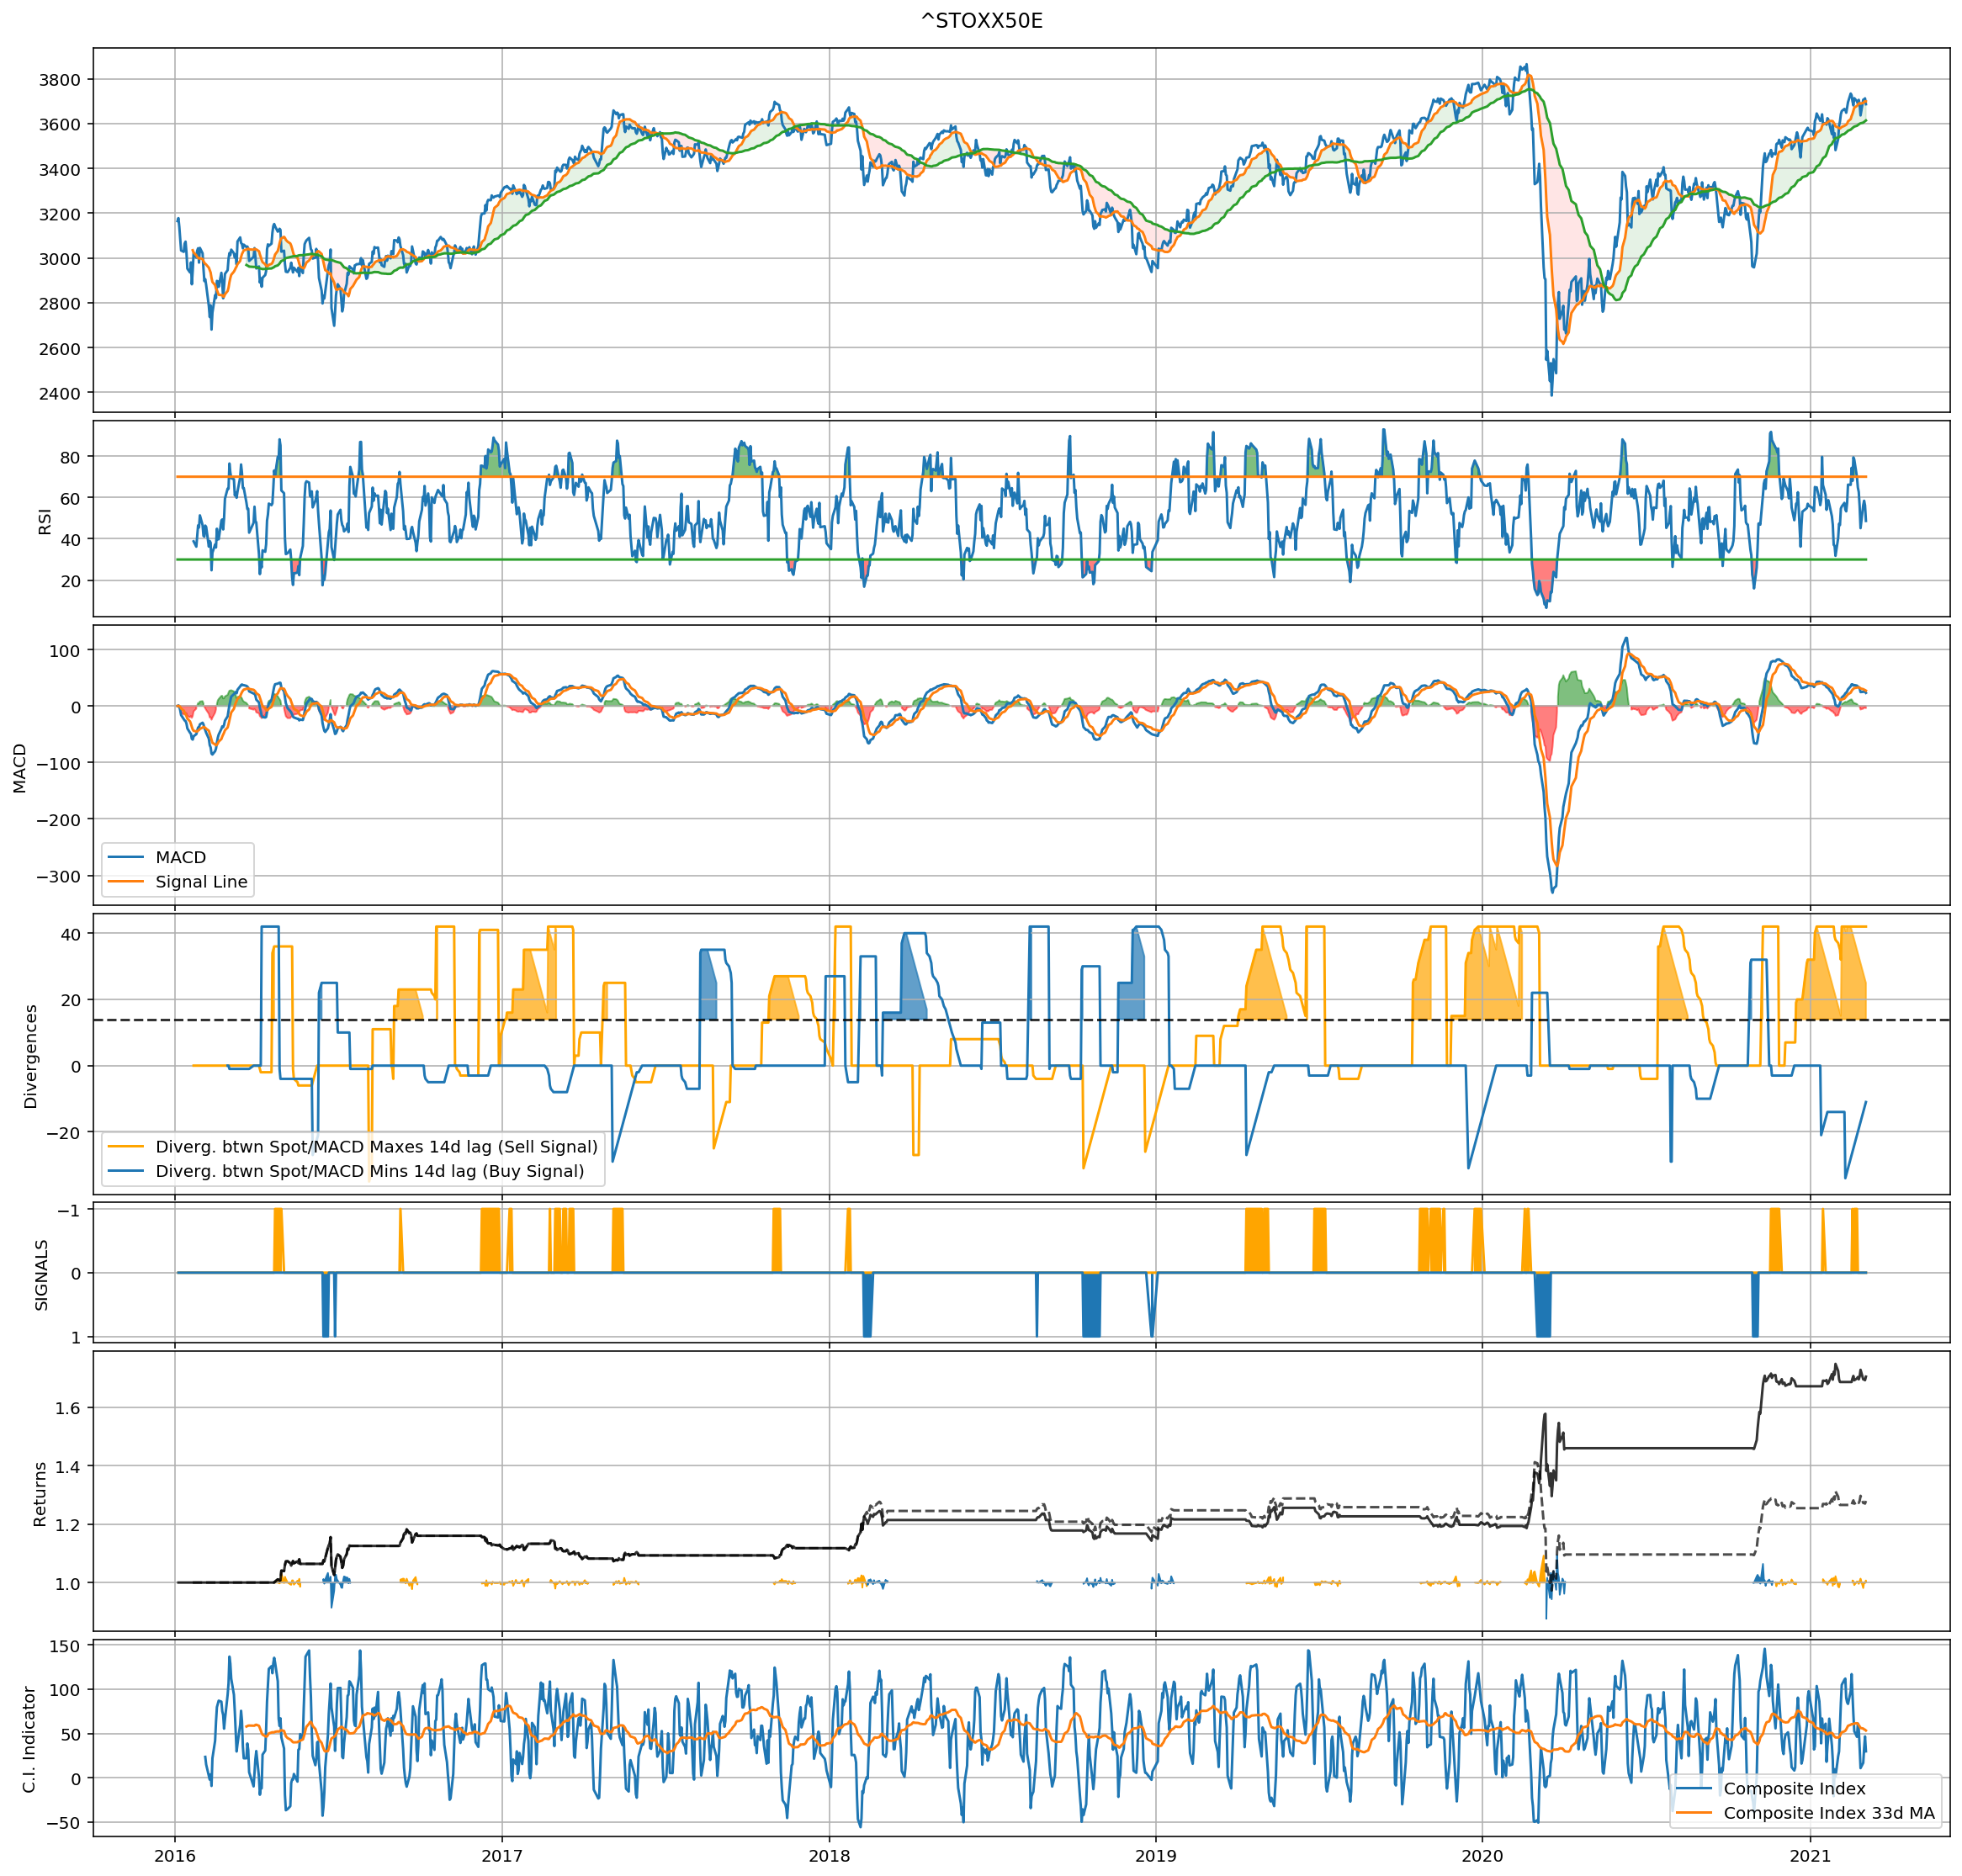

In [10]:
#Inputs
window=14
rsi_width=20
mult=2
print('Cumsum Log Return: ',strategy_builder(asset,df=df_asset,window=window,rsi_width=rsi_width,mult=mult)[0])
indicator_plot(asset,df=df_asset,window=window,rsi_width=rsi_width,mult=mult)

In [11]:
#Creating ranges for parameters over which to iterate and optimise strategy with - use same length (i.e. create a square matrix)
rsi_width_range = np.linspace(5,25,11).astype('int')
mult_range = np.linspace(1.5,3.5,11)
window_range = np.linspace(10,20,11).astype('int')

In [12]:
#Optimise across RSI and Multiplier
strategy_return = np.zeros((len(rsi_width_range),len(mult_range)))
strategy_sharpe = np.zeros((len(rsi_width_range),len(mult_range)))
#window_to_use = window_range[int(len(window_range)/2)]
window_to_use=14

#Iterate through each coord of 2D matrix, and add pnl and sharpe calculation
for i, m in enumerate(mult_range):
    for j, r in enumerate(rsi_width_range):
        pnl,sharpe,_ = strategy_builder(asset=asset,df=df_asset,window=window_to_use,rsi_width=r,mult=m)
        strategy_return[i,j] = pnl
        strategy_sharpe[i,j] = sharpe
        
print('Window used=',window_to_use)

#Return coords of pnl maximising params, and display values
i_,j_ = np.unravel_index(np.nanargmax(strategy_return),strategy_return.shape)
strategy_return[i_,j_]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))  
sns.heatmap(strategy_return,xticklabels=np.round(mult_range,2),yticklabels=rsi_width_range,
            annot=True,cmap='RdBu',center=0,cbar_kws={'label': 'Returns'},ax=ax1).invert_yaxis()
ax1.set_title('Returns: Optimal rsi_width=%.1f' %rsi_width_range[i_] + ', multiplier=%.2f' %mult_range[j_],fontdict={'fontsize':14})
ax1.set_xlabel('Multiplier')
ax1.set_ylabel('RSI Width')

#Return coords of sharpe maximising params, and display values
_i_,_j_ = np.unravel_index(np.nanargmax(strategy_sharpe),strategy_return.shape)
strategy_sharpe[_i_,_j_]

sns.heatmap(strategy_sharpe,xticklabels=np.round(mult_range,2),yticklabels=rsi_width_range,
            annot=True,cmap='RdYlGn',center=0,cbar_kws={'label': 'Sharpe'},ax=ax2).invert_yaxis()
ax2.set_title('Sharpe: Optimal rsi_width=%.1f' %rsi_width_range[_i_] + ', multiplier=%.2f' %mult_range[_j_],fontdict={'fontsize':14})
ax2.set_xlabel('Multiplier')
ax2.set_ylabel('RSI Width')
plt.show()

Window used= 14


In [13]:
strategy_return = np.zeros((len(rsi_width_range),len(window_range)))
strategy_sharpe = np.zeros((len(rsi_width_range),len(window_range)))

#mult_to_use =mult_range[j_]  #PNL optimising mult from above
mult_to_use = 2

for i, r in enumerate(rsi_width_range):
    for j, w in enumerate(window_range):
        pnl,sharpe,_ = strategy_builder(asset=asset,df=df_asset,window=w,rsi_width=r,mult=mult_to_use)
        strategy_return[i,j] = pnl
        strategy_sharpe[i,j] = sharpe

print('Mult used=',mult_to_use)
        
i_,j_ = np.unravel_index(np.nanargmax(strategy_return),strategy_return.shape)
strategy_return[i_,j_]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))  
sns.heatmap(strategy_return,xticklabels=window_range,yticklabels=rsi_width_range,
            annot=True,cmap='RdBu',center=0,cbar_kws={'label': 'Returns'},ax=ax1).invert_yaxis()
ax1.set_title('Returns: Optimal rsi_width=%.1f' %rsi_width_range[i_] + ', window=%.1f' %window_range[j_],fontdict={'fontsize':14})
ax1.set_xlabel('Window')
ax1.set_ylabel('RSI Width')

_i_,_j_ = np.unravel_index(np.nanargmax(strategy_sharpe),strategy_return.shape)
strategy_sharpe[_i_,_j_]

sns.heatmap(strategy_sharpe,xticklabels=window_range,yticklabels=rsi_width_range,
            annot=True,cmap='RdYlGn',center=0,cbar_kws={'label': 'Sharpe'},ax=ax2).invert_yaxis()
ax2.set_title('Sharpe: Optimal rsi_width=%.1f' %rsi_width_range[_i_] + ', window=%.1f' %window_range[_j_],fontdict={'fontsize':14})
ax2.set_xlabel('Window')
ax2.set_ylabel('RSI_width')
plt.show()

Mult used= 2


RSI width used= 11


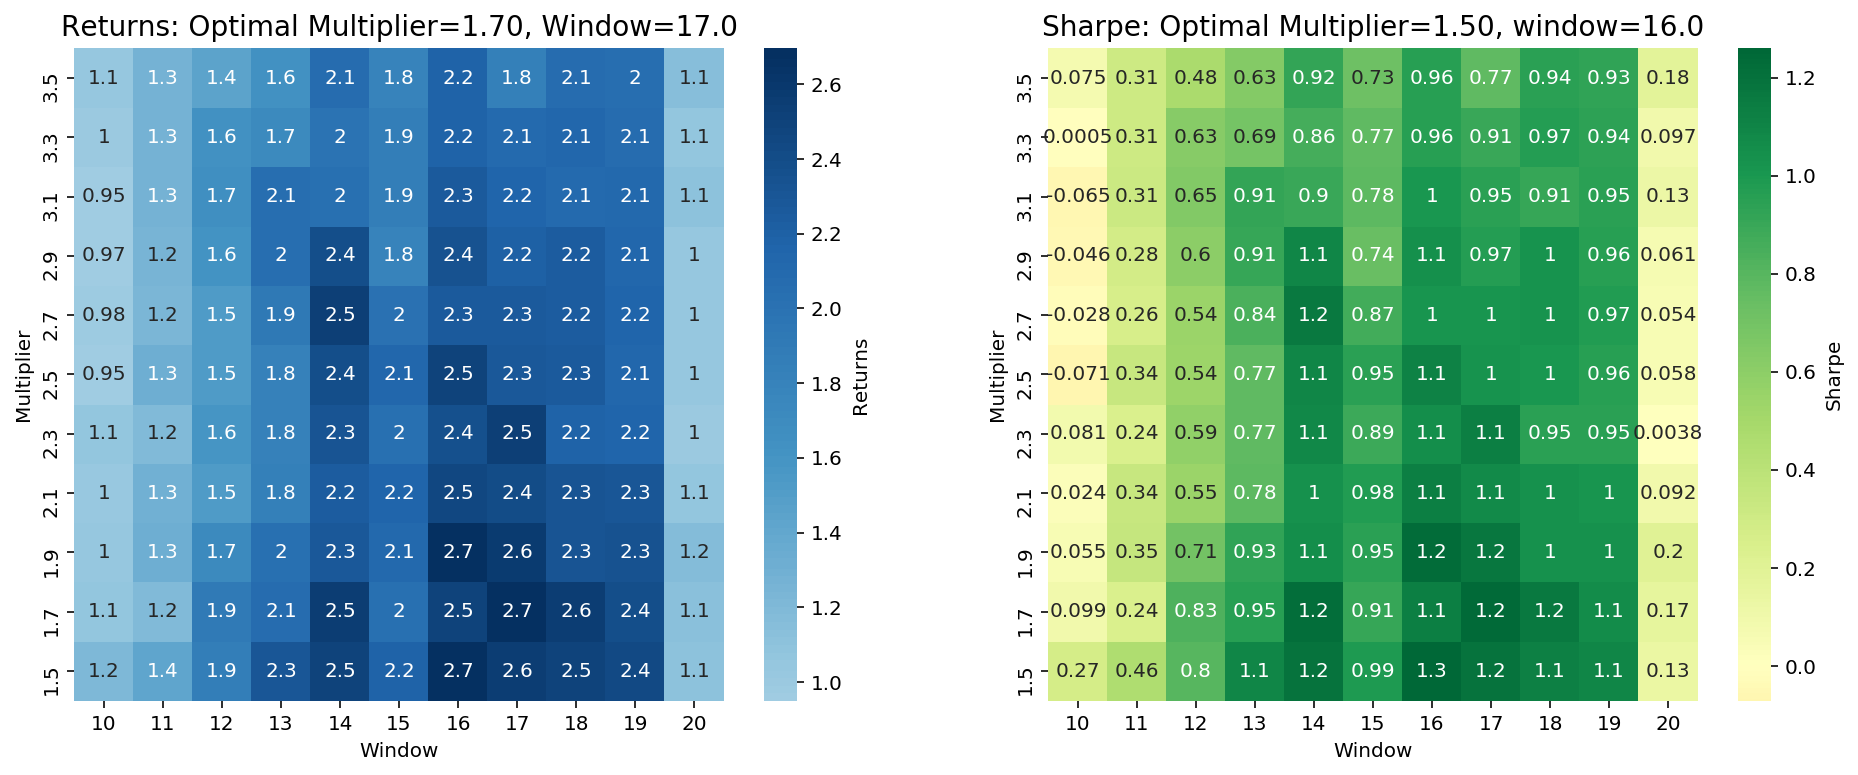

In [14]:
strategy_return = np.zeros((len(mult_range),len(window_range)))
strategy_sharpe = np.zeros((len(mult_range),len(window_range)))
rsi_to_use=rsi_width_range[i_]   #PNL optimsing rsi from above

for i, m in enumerate(mult_range):
    for j, w in enumerate(window_range):
        pnl,sharpe,_ = strategy_builder(asset=asset,df=df_asset,window=w,rsi_width=rsi_to_use,mult=m)
        strategy_return[i,j] = pnl
        strategy_sharpe[i,j] = sharpe
        
print('RSI width used=',rsi_to_use)

i_,j_ = np.unravel_index(np.nanargmax(strategy_return),strategy_return.shape)
strategy_return[i_,j_]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))  
sns.heatmap(strategy_return,xticklabels=window_range,yticklabels=np.round(mult_range,2),
            annot=True,cmap='RdBu',center=0,cbar_kws={'label': 'Returns'},ax=ax1).invert_yaxis()
ax1.set_title('Returns: Optimal Multiplier=%.2f' %mult_range[i_] + ', Window=%.1f' %window_range[j_],fontdict={'fontsize':14})
ax1.set_xlabel('Window')
ax1.set_ylabel('Multiplier')

_i_,_j_ = np.unravel_index(np.nanargmax(strategy_sharpe),strategy_return.shape)
strategy_sharpe[_i_,_j_]

sns.heatmap(strategy_sharpe,xticklabels=window_range,yticklabels=np.round(mult_range,2),
            annot=True,cmap='RdYlGn',center=0,cbar_kws={'label': 'Sharpe'},ax=ax2).invert_yaxis()
ax2.set_title('Sharpe: Optimal Multiplier=%.2f' %mult_range[_i_] + ', window=%.1f' %window_range[_j_],fontdict={'fontsize':14})
ax2.set_xlabel('Window')
ax2.set_ylabel('Multiplier')
plt.show()

  Returns Cumsum()=    Sharpe= 
 (2.3236841710196203, 1.114093079145003)


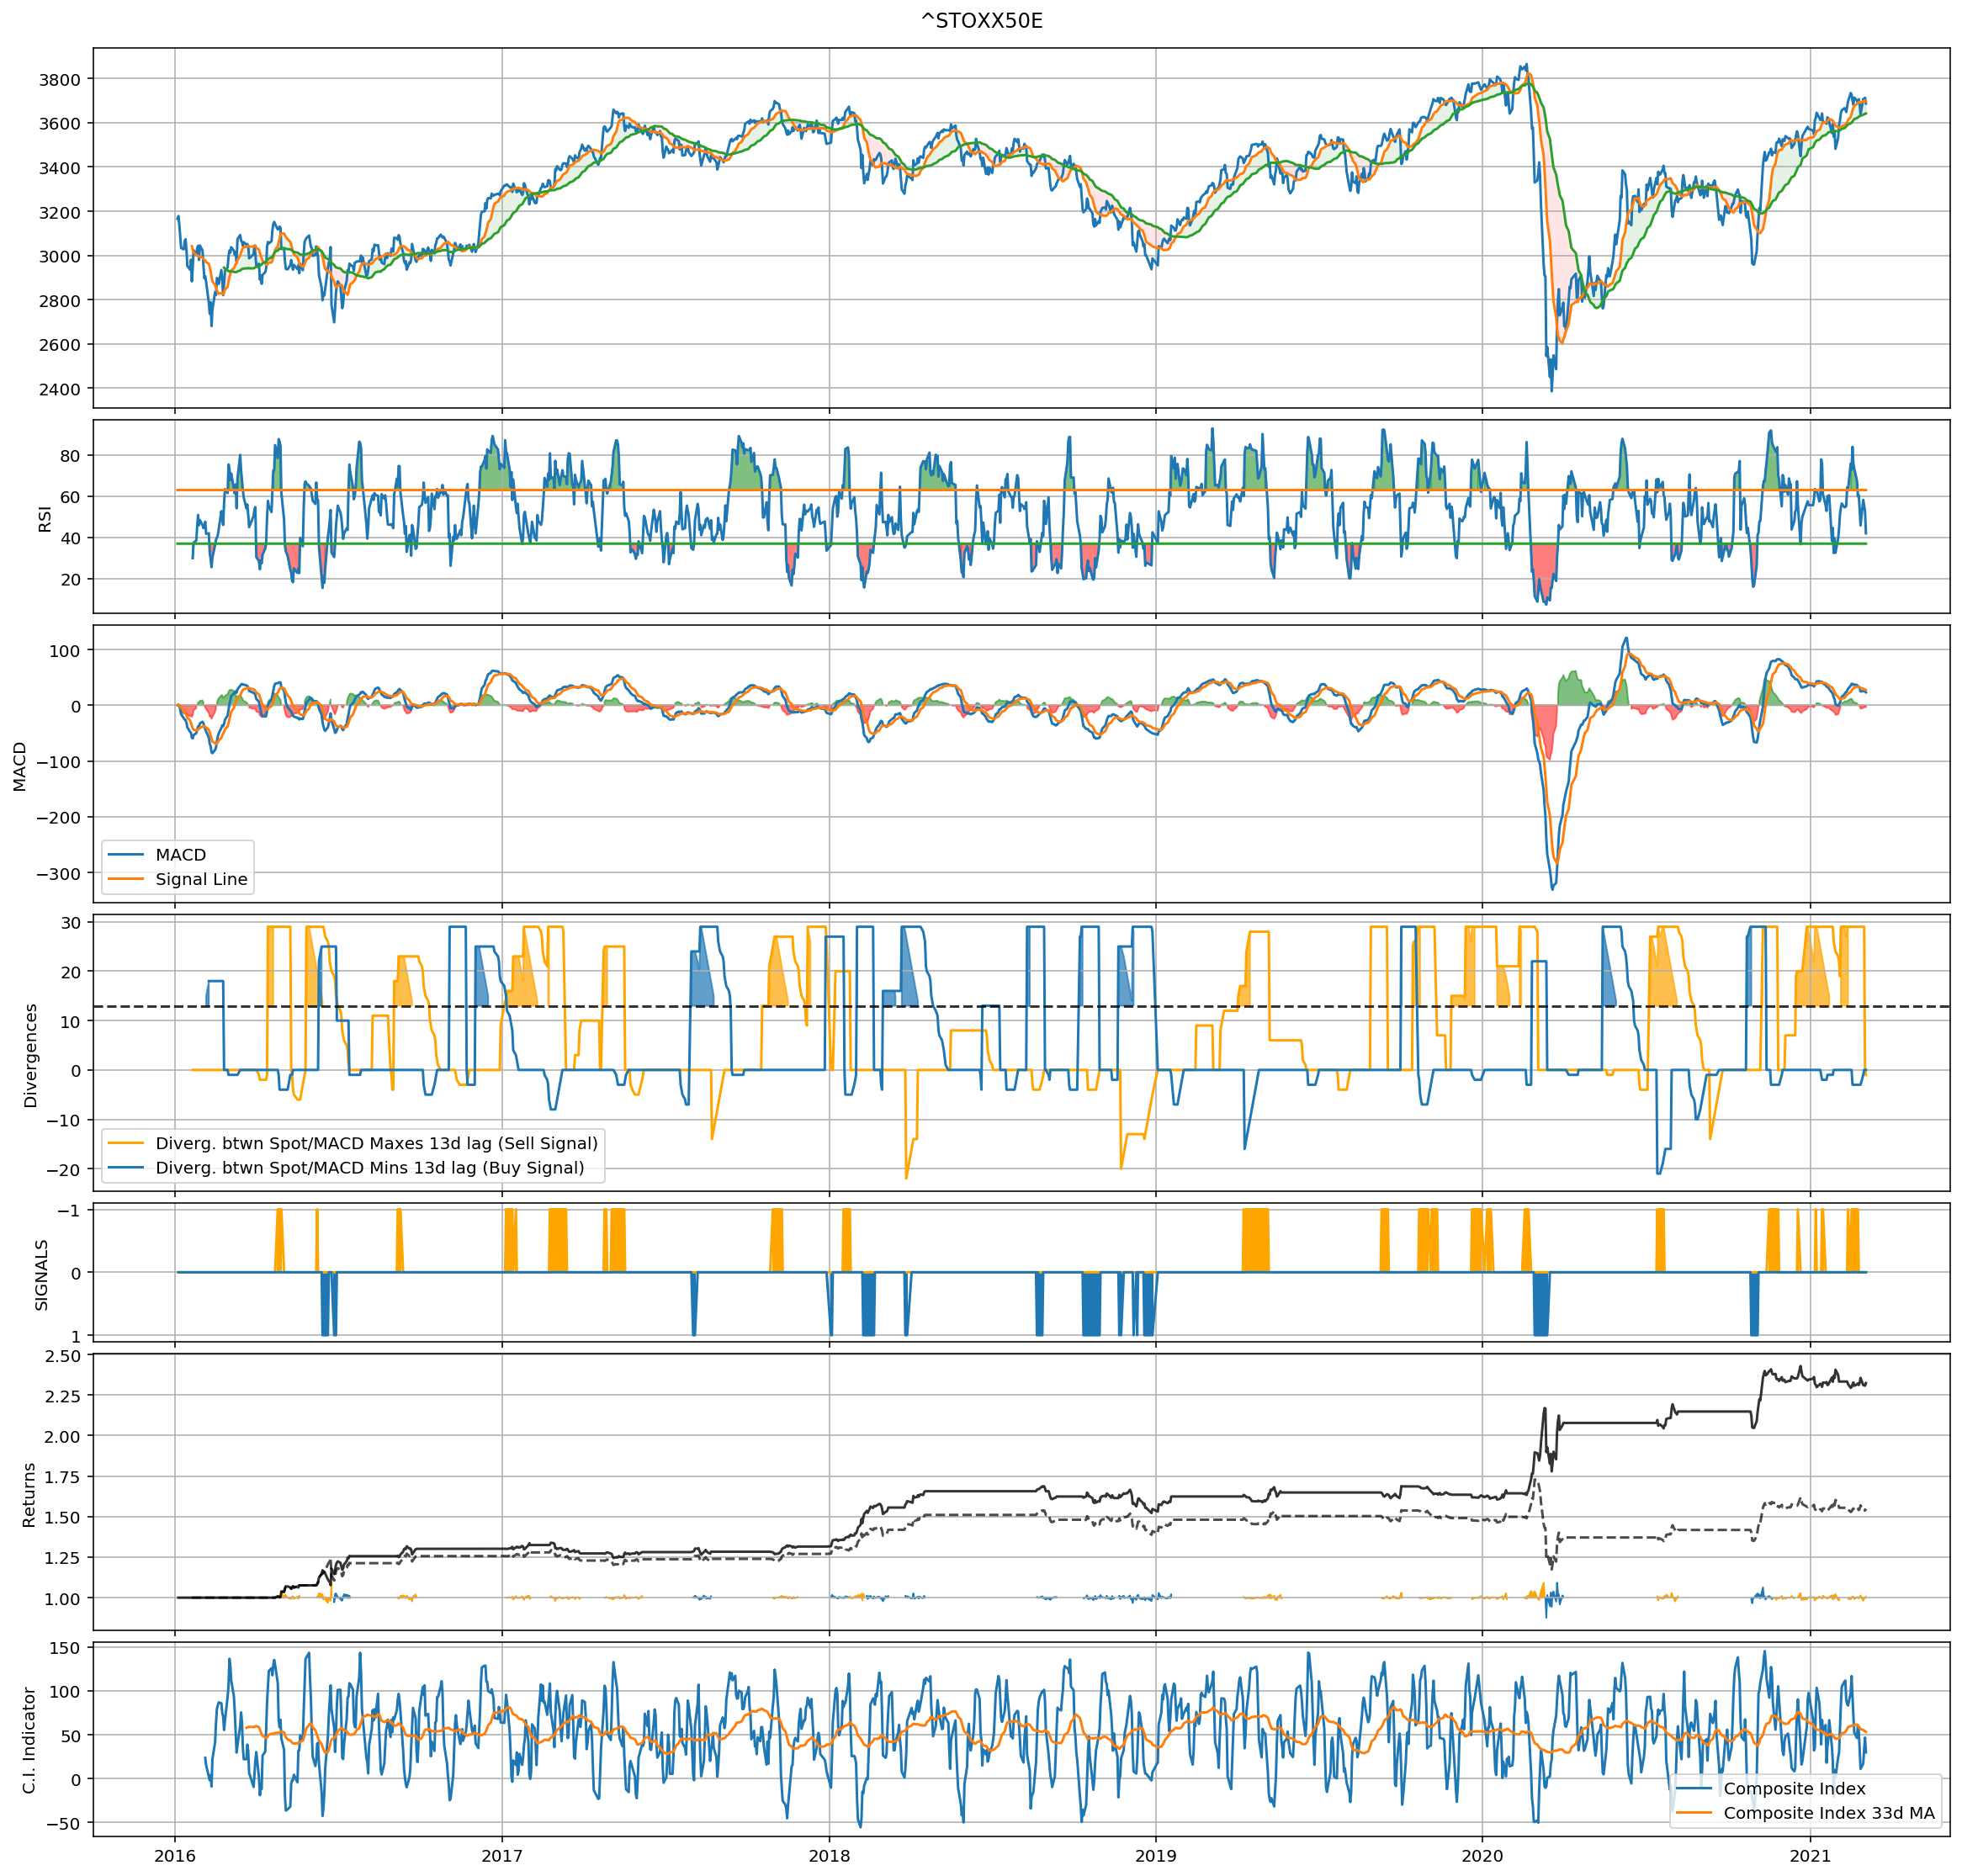

In [15]:
#Optimised param inputs
window=13
rsi_width=13
mult=1.5

print('  Returns Cumsum()=    Sharpe=','\n',itemgetter(0,1)(strategy_builder(asset=asset,df=df_asset,window=window,rsi_width=rsi_width,mult=mult)))
indicator_plot(asset=asset,df=df_asset,window=window,rsi_width=rsi_width,mult=mult)

In [16]:
#Create 3D scatter plot of parameter ranges
strategy_return_3 = strategy_sharpe_3 = np.zeros((len(rsi_width_range),len(mult_range),len(window_range)))

for i, r in enumerate(rsi_width_range):
    for j, m in enumerate(mult_range):
        for k, w in enumerate(window_range):
            pnl,sharpe,_ = strategy_builder(asset=asset,df=df_asset,window=w,rsi_width=r,mult=m)
            strategy_return_3[i,j,k] = pnl
            #strategy_sharpe_3[i,j,k] = sharpe

In [17]:
#check shape of 3D array
print(strategy_return_3.shape)

(11, 11, 11)


In [18]:
#return indices 
nonzero = (strategy_return_3).nonzero()    #could use np.where to filter for only positive returns etc.
z,x,y = nonzero

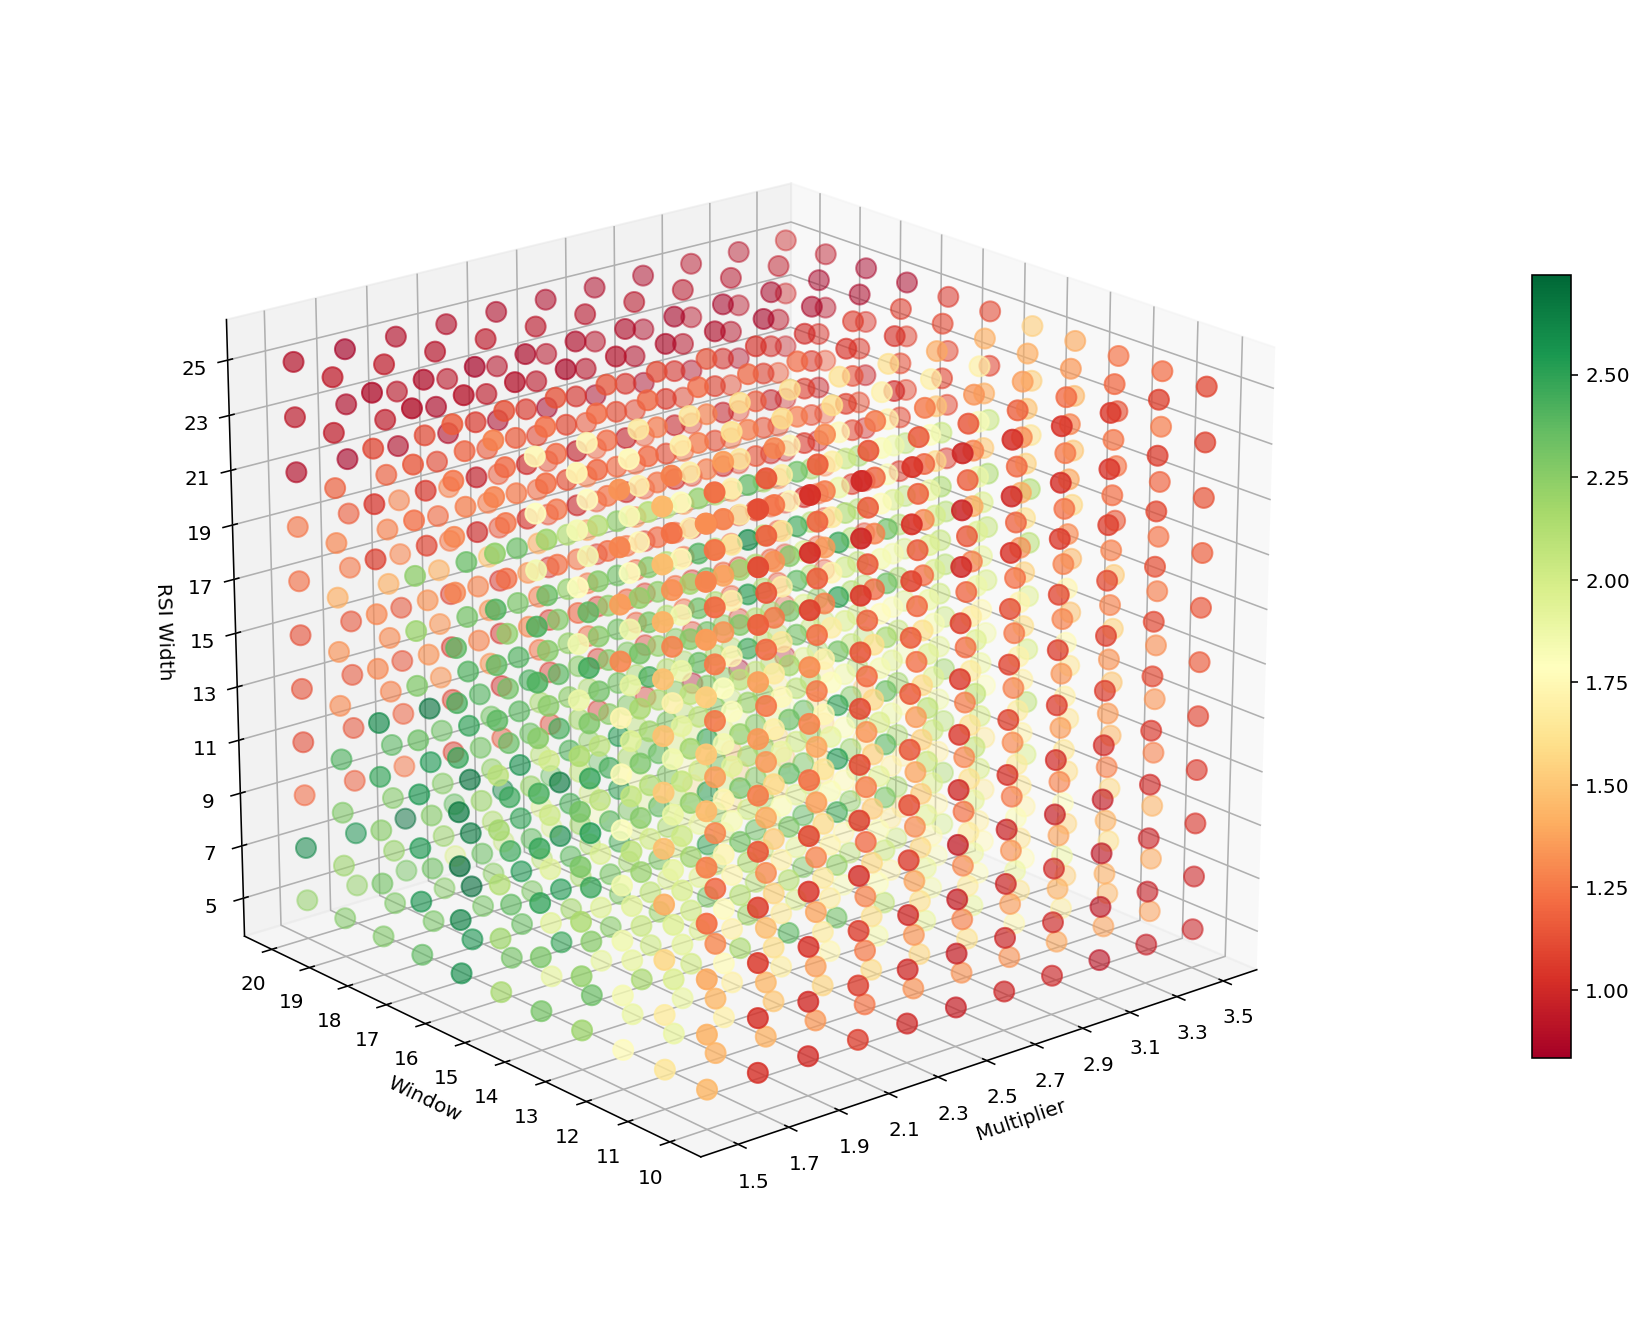

MAX RETURN =  2.74284533229611


In [19]:
#Plot 3D array
fig = plt.figure(figsize=(16,12))
ax=fig.add_subplot(111,projection='3d')

#4th dim = c = strategy_return_3.ravel()
g = ax.scatter(x, y, z , zdir='z', c=strategy_return_3.ravel(), cmap='RdYlGn', 
               marker='o', s=100) 

ax.view_init(elev=22, azim=230)
ax.dist=11

#display colorbar
plt.colorbar(g,shrink=0.6)

#Axis ticks and labels
ax.set_xticks(np.arange(len(mult_range)))
ax.set_xticklabels(np.round(mult_range,2)) #,ha='right')
ax.set_xlabel('Multiplier')

ax.set_yticks(np.arange(len(window_range)))
ax.set_yticklabels(window_range) #,ha='right')
ax.set_ylabel('Window')

ax.set_zticks(np.arange(len(rsi_width_range)))
ax.set_zticklabels(rsi_width_range) #,ha='right')
ax.set_zlabel('RSI Width')

plt.show()

print('MAX RETURN = ',np.max(strategy_return_3))

In [20]:
import pyfolio as pf
a = strategy_builder(asset,df=df_asset,window=13,rsi_width=13,mult=1.5)[2]
pf.create_returns_tear_sheet(a['position_returns_first'])